In [1]:
import thulac
import os
import re
import pandas as pd
from gensim.models import Word2Vec
import jieba
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import pandas as pd
import jieba
import jieba.analyse
import jieba.posseg as posg

In [9]:
# 停词表
# 停词表

def load_stop_word():
    stop_word = ['的', '。', '是', ' ', '\n', '日', '月', '.', '%','\u3000']
    stop_word_file = 'c:/data/stopwords'
    stop_word_dirs = os.listdir(stop_word_file)
    for textName in stop_word_dirs:
        filename = stop_word_file + '/' + textName
        with open(filename, 'r', encoding='utf-8') as file_object:
            line = file_object.readline()
            while line:
                stop_word.append(line[0:-1])
                line = file_object.readline()
    return stop_word
stop_word = load_stop_word()
print("停词表", stop_word[0:10])
#分词
 # 默认模式，分词的同时进行词性标注
# thu = thulac.thulac(filt=True, seg_only=True)
word_type = dict()
type_num = dict()
def cut_doc(doc):
     # 默认模式，分词的同时进行词性标注
    
    words = posg.cut(doc)
    words_in_doc = ""
    for w in words:
        # print(word)
        if w.word in stop_word: continue
        words_in_doc +=  w.word + " "
        word_type[w.word] = w.flag
        try:
            type_num[w.flag] = type_num[w.flag] + 1
        except Exception as e:
            type_num[w.flag] = 1
            continue
        
    return words_in_doc

words_in_doc = cut_doc("用来控制训练的文章数量")
words_in_doc,word_type,type_num

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\hys\AppData\Local\Temp\jieba.cache


停词表 ['的', '。', '是', ' ', '\n', '日', '月', '.', '%', '\u3000']


Loading model cost 0.437 seconds.
Prefix dict has been built successfully.


('控制 训练 文章 数量 ',
 {'控制': 'v', '训练': 'vn', '文章': 'n', '数量': 'n'},
 {'v': 1, 'vn': 1, 'n': 2})

In [ ]:
doc_map = {}
label_map = {}
map = {}
DOC_COUNT_MAX = 100
wrong_num = []

def read_file_cut(doc_file_name, doc_id, label_index):
    with open(doc_file_name, 'r', encoding='utf-8') as file_object:
        doc_content = ""
        line = file_object.readline()
        while line:
            doc_content += line
            line = file_object.readline()
        wrong = 1
        for _ in range(0,4):
            try:
                doc_map[doc_id] = cut_doc(doc_content)
                wrong = 0
                break
            except Exception as e:
                continue
        if wrong == 1:
            wrong_num.append(doc_id)
        label_map[doc_id] = int(label_index)
    return 0

my_df = pd.DataFrame([],index=[],columns=['text','label'])

label_num = {}

with ThreadPoolExecutor(max_workers= int(10000)) as t:
    obj_list = []
    begin = time.time()
    
    news_file = 'c:/data/THUCNews'
    news_file_dirs = os.listdir(news_file)
    # print(news_file_dirs)
    
    label_index = -1
    for label in news_file_dirs:
        label_index += 1
        label_num[label] = label_index
        
        file = news_file + '/' + label
        doc_ids = os.listdir(file)
        doc_num = 0
        for doc_name in doc_ids:
            doc_num += 1
            if doc_num >= DOC_COUNT_MAX:
                break
                
            doc_file_name = file + '/' + doc_name
            doc_id = doc_name[0:-4]
            doc_content = ""
            
            
            obj = t.submit(read_file_cut, doc_file_name, doc_id, label_index)
            obj_list.append(obj)    
            
      
    for future in as_completed(obj_list):
        data = future.result()
    times = time.time() - begin
    print("多线程占据的全部时间"+str(times))
    print(len(obj_list))
    print(len(doc_map))
    print(len(label_map))
    
map['text'] = doc_map
map['label'] = label_map


my_df = pd.DataFrame(map)
train_df = my_df
print("错误的次数", len(wrong_num) )
print(train_df.shape)
train_df.to_csv("c:/data/news/test01.csv")

In [17]:
doc_map = {}
label_map = {}
label_name_map = {}
map = {}
DOC_COUNT_MAX = 10000
wrong_num = []

def read_file2_cut():
    doc_file_name ='C:/data/TNEWS/toutiao_cat_data.txt'
    with open(doc_file_name, 'r', encoding='utf-8') as file_object:
        doc_content = ""
        line = file_object.readline()
        j = 0
        while line:
            j += 1
            if j>DOC_COUNT_MAX:break
            doc_content = str(line)
            line = file_object.readline()
            news_detail = doc_content.split("_!_")
#             print(news_detail)
            doc_id,label,label_name,doc_content = news_detail[0],news_detail[1][1:],news_detail[2],news_detail[3]
#             print(doc_id,label,label_name,doc_content)
            label_name_map[doc_id] = str(label_name)
            wrong = 0
            for _ in range(0,4):
                try:
                    
                    doc_map[doc_id] = cut_doc(doc_content)
                    wrong = 0
                    break
                except Exception as e:
                    continue
            if wrong == 1:
                wrong_num.append(doc_id)
            label_map[doc_id] = int(label)
            
        my_df = pd.DataFrame([],index=[],columns=['text','label'])
        label_num = {}
        map['text'] = doc_map
        map['label'] = label_map
        map['label_name'] = label_name_map


        my_df = pd.DataFrame(map)
        train_df = my_df
        print("错误的次数", len(wrong_num) )
        print(train_df.shape)
        train_df.to_csv("c:/data/news/test_tnews.csv")
    return train_df


train_df = read_file2_cut()
train_df.head()

错误的次数 0
(10000, 3)


,text,label,label_name
6551700932705387022,京城 值得 来场 文化 旅 博物馆,1,news_culture
6552368441838272771,发酵 床 垫料 种类 更好,1,news_culture
6552407965343678723,上联 黄山 黄河 黄皮肤 黄土高原 下联,1,news_culture
6552332417753940238,林徽因 理由 拒绝 徐志摩 选择 梁思成 终身伴侣,1,news_culture
6552475601595269390,黄杨木 树,1,news_culture


In [18]:
my_df = train_df

In [19]:
%matplotlib  inline
train_df = my_df
train_df['text_len'] = train_df['text'].apply(lambda x: len(x.split(' ')))
print(train_df['text_len'].describe())

count    10000.000000
mean         8.477400
std          3.086072
min          2.000000
25%          6.000000
50%          8.000000
75%         11.000000
max         23.000000
Name: text_len, dtype: float64


Text(0, 0.5, '文本个数')

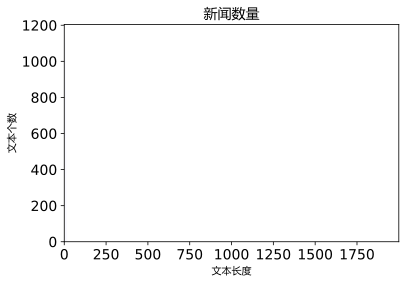

In [20]:
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'svg'
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\msyh.ttc", size=15)

_ = plt.hist(train_df['text_len'], bins=1000)
plt.xlabel('Text char count')
plt.title("Histogram of char count")
# x_values=list(range(0,1000,50))
# #x轴的数字是0到10这11个整数
# y_values=[x/10 for x in x_values]
plt.xlim(0,2000)
plt.xticks((range(0,2000,250)))
#用plot函数绘制折线图，线条颜色设置为绿色
plt.title('新闻数量',fontsize=14, fontproperties=font)
#设置图表标题和标题字号
plt.tick_params(axis='both',which='major',labelsize=14)
#设置刻度的字号
plt.xlabel('文本长度',fontsize=10, fontproperties=font)
#设置x轴标签及其字号
plt.ylabel('文本个数',fontsize=10, fontproperties=font)
#设置y轴标签及其字号

In [10]:
type(type_num)
all_num = 0
type_num_list = sorted(type_num.items(), key=lambda item:item[1], reverse=True)
for x in type_num_list:
    all_num += x[1]

type_num_list = type_num_list[0:11]
x_type_list = [x[0] for x in type_num_list]
y_num_list = [x[1]/all_num for x in type_num_list]

index = -1
for i in range(len(x_type_list)):
    if x_type_list[i] == 'm':
        index = i
        break
if index != -1:
    x_type_list.pop(index)
    y_num_list.pop(index)

type_num_list,x_type_list,y_num_list

([('n', 117057),
  ('v', 72605),
  ('m', 26972),
  ('nr', 17257),
  ('ns', 13533),
  ('a', 12926),
  ('vn', 11754),
  ('d', 10605),
  ('eng', 8432),
  ('t', 5728),
  ('nz', 4552)],
 ['n', 'v', 'nr', 'ns', 'a', 'vn', 'd', 'eng', 't', 'nz'],
 [0.3448776722370189,
  0.21391154217832983,
  0.05084321304829472,
  0.03987142621443892,
  0.038083060315365215,
  0.034630070473990616,
  0.031244844085134466,
  0.02484267094067457,
  0.016876045914158436,
  0.013411271124519763])

NameError: name 'x_type_list' is not defined

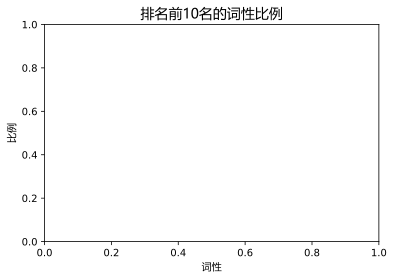

In [21]:
#用plot函数绘制折线图，线条颜色设置为绿色
plt.title('排名前10名的词性比例',fontsize=14, fontproperties=font)
#设置图表标题和标题字号
# plt.tick_params(axis='both',which='major',labelsize=14)
#设置刻度的字号
plt.xlabel('词性',fontsize=10, fontproperties=font)
#设置x轴标签及其字号
plt.ylabel('比例',fontsize=10, fontproperties=font)
plt.bar(x_type_list, y_num_list)
plt.show()

Text(0.5, 1.0, 'Histogram of char count')

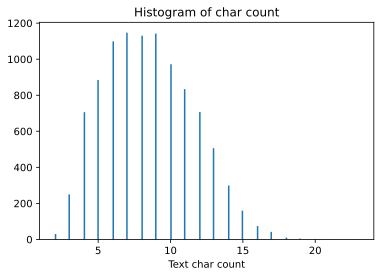

In [22]:
_ = plt.hist(train_df['text_len'], bins=200)
plt.xlabel('Text char count')
plt.title("Histogram of char count")

Text(0, 0.5, '文本个数')

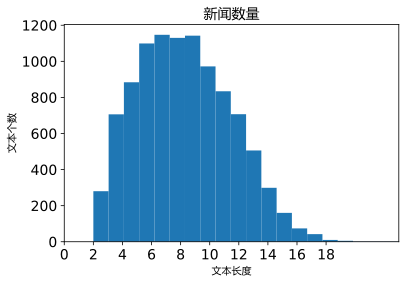

In [29]:
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'svg'
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\msyh.ttc", size=10)

_ = plt.hist(train_df['text_len'], bins=20)
plt.xlabel('Text char count')
plt.title("Histogram of char count")
# x_values=list(range(0,1000,50))
# #x轴的数字是0到10这11个整数
# y_values=[x/10 for x in x_values]
plt.xlim(0,23)
plt.xticks((range(0,20,2)))
#用plot函数绘制折线图，线条颜色设置为绿色
plt.title('新闻数量',fontsize=14, fontproperties=font)
#设置图表标题和标题字号
plt.tick_params(axis='both',which='major',labelsize=14)
#设置刻度的字号
plt.xlabel('文本长度',fontsize=10, fontproperties=font)
#设置x轴标签及其字号
plt.ylabel('文本个数',fontsize=10, fontproperties=font)
#设置y轴标签及其字号

# word2Vec 文本向量化


In [30]:
# 基于 word2vec 生成 词向量
import numpy as np
useless = set()

doc_data = train_df['text']
doc_data

6551700932705387022                京城 值得 来场 文化 旅 博物馆 
6552368441838272771                    发酵 床 垫料 种类 更好 
6552407965343678723             上联 黄山 黄河 黄皮肤 黄土高原 下联 
6552332417753940238        林徽因 理由 拒绝 徐志摩 选择 梁思成 终身伴侣 
6552475601595269390                            黄杨木 树 
                                    ...              
6552353086776541699    高考 白卷 考生 10 年后 考取 大专 当年 确实 值得 
6552251734922625288                          见 努力 样子 
6552319670509109511    大二 下学期 不想 住 宿舍 喜欢 学习 家庭 经济 条件 
6552420405481570573                  纳粹 发明 纳粹 钟 黑 科技 
6552448351806161412                  马云 英雄所见略同 想法 碰到 
Name: text, Length: 10000, dtype: object

In [31]:
# word2Vec 文本向量化

# # 基于 word2vec 生成 词向量
# import numpy as np
# useless = set()

# doc_data = train_df['text']


common_text = []
for i in range(0, doc_data.size):
    doc = str(doc_data[i]).split(" ")
    common_text.append(doc)

# 词向量的维度，样本够的话300-500。
# min_count 最小次数计数，出现次数低于这个数的就不要了
# workers  线程数
# window 窗口大小
# sample 负例采样设置aa


vector_size = 500
model = Word2Vec(sentences=common_text, vector_size=vector_size, window=5, min_count=4,
                  workers=12, sample=1e-5)
# model.save("word2vec.model")
vector = model.wv['中国']

# 词向量 合成 文本向量
doc_v_list = np.array([])

for split_doc in common_text:
    used_word = float(0.0)
    vector = vector * 0
    for word in split_doc:

        used_word += 1.0
        try:
            vector += model.wv[word]
        except Exception as e:
            # print(e.__traceback__.tb_frame.f_globals["__file__"])  # 发生异常所在的文件
            # print(e.__traceback__.tb_lineno)  # 发生异常所在的行数
            used_word -= 1.0

    vector /= used_word /200
    doc_v_list = np.append(doc_v_list, vector)

train_test = doc_v_list.reshape(len(common_text), vector_size)
train_test.shape

(10000, 500)

In [32]:
# 基于bert的文本向量化

In [51]:
from transformers import BertTokenizer,BertModel
from pprint import pprint
from transformers import BertModel

vocab_file = '../aliYunCls/BertModel/bert-base-chinese-vocab.txt'
tokenizer = BertTokenizer(vocab_file)
model = BertModel.from_pretrained('../aliYunCls/BertModel/bert-base-chinese')
    
def word_to_vec(word, sequence):
     # sequence 待分词的句子
     # sequence = "苹果好的手机" 
    sequence = str(sequence)
    tokenized_sequence = tokenizer.tokenize(sequence)  # 调用tokenize方法进行分词
    #print(tokenized_sequence)  # 输出
    inputs = tokenizer([sequence],return_tensors='pt')
    encoded_sequence = inputs["input_ids"] 
    #pprint(inputs)
    out = model(**inputs)
    x = out['last_hidden_state'][0][0]
    x = x * 0
    
    word_id = []
 
    x = word[0]
    for i in range(0,len(sequence)):
        if x == sequence[i:i+len(x)]:
            word_id.append(i)
            
    
    for id in word_id:
        x = out['last_hidden_state'][0][id]  
        
    return x
doc1 = '苹果 是 很好 的 手机'
vec1 = word_to_vec('苹果', doc1)
print(vec1.shape)

Some weights of the model checkpoint at ../aliYunCls/BertModel/bert-base-chinese were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([768])


In [22]:
train_df

,text,label,text_len
0,马晓旭 意外 受伤 国奥 警惕 无奈 大雨 青睐 殷家 军 记者 傅亚雨 沈阳 报道 来到 ...,0,216
1,商瑞华 首战 复仇 心切 中国 玫瑰 美国 方式 攻克 瑞典 多曼 瑞典 商瑞华 首战 求 ...,0,465
10000,阿的江 八一 需 定位 机会 进 没进 新浪 体育讯 12 24 回到 主场 北京 金隅 迎...,0,273
100,辽 足 签约 危机 引 注册 难关 高层 威逼利诱 合同 笑里藏刀 新浪 体育讯 24 辽 ...,0,419
1000,揭秘 谢亚龙 带走 总局 电话 骗局 复制 南杨 轨迹 体坛周报 特约记者 张锐 北京 报道...,0,254
...,...,...,...
798981,亚洲 燃料油 裂解 价差 收 窄 跨 合约 遭 单 抛售 文华 财经 编辑整理 丽丽 新加坡...,13,211
798983,欧佩克 特别 会议 大幅度 减产 新华网 阿尔及尔 10 18 日电 记者 郑斌 阿尔及利亚...,13,129
798985,价格 太 高 中国 连续 两周 未 进口 美国 大豆 卢进 高 企 美国 大豆价格 令 买家...,13,238
798984,中国 2010 年 棉花 产量 预计 减少 5.5 新浪 财经 讯 11 18 下午 消息 ...,13,135


In [34]:
# Count Vectors + RidgeClassifier

import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import f1_score

all_data_size = 10000
train_data_size = 8000
test_data_size = all_data_size - train_data_size

# train_df = pd.read_csv('./data/train_set.csv', sep='\t', nrows=all_data_size)

# vectorizer = CountVectorizer(max_features=300)
# train_test = vectorizer.fit_transform(train_df['text'])

print(train_df['label'].values[train_data_size:])

clf = RidgeClassifier()
clf.fit(train_test[:train_data_size], train_df['label'].values[:train_data_size])

val_pred = clf.predict(train_test[train_data_size:])
# print("预测结果",val_pred)
# print("实际标签",train_df['label'].values[train_data_size:])
print(f1_score(train_df['label'].values[train_data_size:], val_pred, average='macro'))
# 0.28



[4 4 6 ... 8 9 9]
0.5814521432213517


In [48]:
word_id = []
word = "苹果"
x = word[0]
print(x)
sequence ="多吃苹果"
for i in range(0,len(sequence)):
    if x == sequence[i:i+len(x)]:
        word_id.append(i)
word_id  

苹


[2]

In [54]:
label_map.values()

AttributeError: 'dict_values' object has no attribute 'max'